In [1]:
%%capture
!pip install gdown transformers >> /dev/null
!gdown 15ccaDbz7woXub_zpszqkfy5D-iimJ0_w
!unzip /kaggle/working/train.zip -d /kaggle/working
!mkdir /kaggle/working/result

In [2]:
import torch
from torch import nn
from torch.utils.data import Dataset, random_split, DataLoader

from torchvision import transforms

from PIL import Image
import glob
import numpy as np
import cv2
import os
from tqdm import tqdm
from matplotlib import pyplot as plt

%matplotlib inline

In [3]:
class VKStickerDataset(nn.Module):
    def __init__(self, img_dir, size, center_crop=False):
        super().__init__()
        self.images = glob.glob(img_dir)
        self.image_transforms = transforms.Compose(
            [
                transforms.Resize(size, interpolation=transforms.InterpolationMode.BILINEAR),
                transforms.CenterCrop(size) if center_crop else transforms.RandomCrop(size),
                transforms.ToTensor(),
                transforms.Normalize([0.5], [0.5]),
            ]
        )
        self.size = size

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        im = cv2.imread(self.images[idx], cv2.IMREAD_UNCHANGED)
        im = cv2.resize(im, (self.size, self.size))
        ret, mask = cv2.threshold(im[:, :, 3], 0, 255, cv2.THRESH_BINARY)

        mask[mask == 255] = 1
        mask[mask == 0] = 0

        rgb_im = cv2.cvtColor(im, cv2.COLOR_RGBA2RGB)

        rgb_im = torch.Tensor(rgb_im).permute(2, 0, 1)
        mask = torch.Tensor(mask)

        return (rgb_im, mask)

In [4]:
SMOOTH = 1e-6

def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    # outputs = outputs.squeeze(1)  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.type(torch.IntTensor).to("cpu")
    outputs = outputs.to("cpu")
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0

    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0

    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds

    return thresholded

In [5]:
files = glob.glob("/kaggle/working/downloaded/*/*.webp")
removed_files = []

for f in files:
    img = cv2.imread(f, cv2.IMREAD_UNCHANGED)
    try:
        r, g, b, a = cv2.split(img)
    except Exception as e:
        os.remove(f)

In [6]:
EPOCHS = 15
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
data_path = "/kaggle/working/downloaded/*/*.webp"

dataset = VKStickerDataset(data_path, size=256)
train_dataset, val_dataset = random_split(dataset, [0.8, 0.2])

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16)

print(f"Train dataset: {len(train_dataset)}, Val dataset: {len(val_dataset)}")

Train dataset: 6127, Val dataset: 1531


# SegFormer

In [8]:
from transformers import AutoImageProcessor, SegformerForSemanticSegmentation
from PIL import Image
import requests

2024-01-30 07:06:51.158179: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-30 07:06:51.158305: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-30 07:06:51.326816: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [9]:
image_processor = AutoImageProcessor.from_pretrained("nvidia/mit-b0")
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b0", num_labels=2, ignore_mismatched_sizes=True)

preprocessor_config.json:   0%|          | 0.00/272 [00:00<?, ?B/s]

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.
/opt/conda/lib/python3.10/site-packages/transformers/models/segformer/image_processing_segformer.py:101: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


config.json:   0%|          | 0.00/70.0k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/14.4M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.wei

In [10]:
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
criterion = nn.BCEWithLogitsLoss()

### Результаты без дообучения


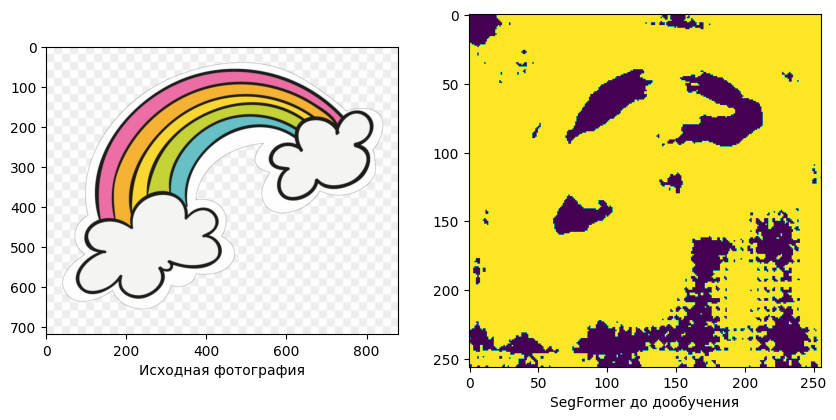

In [11]:
img = Image.open("/kaggle/input/example-image/image.jpg").convert("RGB")
img_tensor = image_processor(img, return_tensors="pt")
img_tensor["pixel_values"] = img_tensor["pixel_values"].to(device)

outputs = model(**img_tensor).logits
outputs = nn.functional.interpolate(outputs, size=(256, 256), mode="bilinear", align_corners=False)
outputs = outputs.argmax(dim=1).permute(1, 2, 0).detach().cpu().numpy()

fig = plt.figure(figsize=(10, 7)) 
fig.add_subplot(1, 2, 1) 
plt.xlabel("Исходная фотография")
plt.imshow(img)

fig.add_subplot(1, 2, 2) 
plt.xlabel("SegFormer до дообучения")
plt.imshow(outputs)

plt.show()

In [12]:
for epoch in range(EPOCHS):
    print(f"EPOCH #{epoch}")
    model.train()

    train_loss = torch.Tensor([])
    for x, y in tqdm(train_dataloader):
        optimizer.zero_grad()
        x = x.to(device)
        y = y.type(torch.LongTensor).to(device)

        outputs = model(pixel_values=x, labels=y)
        loss, logits = outputs["loss"], outputs["logits"]
        loss.backward()
        optimizer.step()

        train_loss = torch.cat((train_loss, torch.Tensor([loss.to("cpu")])), dim=0)

    avg_train_loss = sum(train_loss) / len(train_loss)

    model.eval()
    val_loss = torch.Tensor([])
    val_iou = torch.Tensor([])

    with torch.no_grad():
        for x, y in tqdm(val_dataloader):
            x = x.to(device)
            y = y.type(torch.LongTensor).to(device)

            outputs = model(pixel_values=x, labels=y)
            loss, logits = outputs["loss"], outputs["logits"]

            val_loss = torch.cat((val_loss, torch.Tensor([loss.to("cpu")])), dim=0)

            upsampled_logits = nn.functional.interpolate(logits, size=y.shape[-2:], mode="bilinear", align_corners=False)
            outputs = upsampled_logits.argmax(dim=1)

            i_o_u = iou_pytorch(outputs, y)
            val_iou = torch.cat((val_iou, i_o_u), dim=0)

    avg_val_loss = sum(val_loss) / len(val_loss)
    avg_iou = sum(val_iou) / len(val_iou)

    print(f"train_loss: {avg_train_loss}, \
            val_loss: {avg_val_loss}, \
            iou_score: {avg_iou}")
    if epoch % 5 == 0 and epoch != 0:
        torch.save(model, f"/kaggle/working/result/segformer_epoch{epoch}.pt")

EPOCH #0


100%|██████████| 96/96 [00:12<00:00,  7.63it/s]


train_loss: 0.1334453672170639,             val_loss: 0.07281919568777084,             iou_score: 0.9659077525138855
EPOCH #1


100%|██████████| 96/96 [00:12<00:00,  7.67it/s]


train_loss: 0.06736531108617783,             val_loss: 0.05801376327872276,             iou_score: 0.9725043773651123
EPOCH #2


100%|██████████| 96/96 [00:12<00:00,  7.69it/s]


train_loss: 0.055403925478458405,             val_loss: 0.051876500248909,             iou_score: 0.977663516998291
EPOCH #3


100%|██████████| 96/96 [00:12<00:00,  7.89it/s]


train_loss: 0.04833080992102623,             val_loss: 0.047958213835954666,             iou_score: 0.9804067015647888
EPOCH #4


100%|██████████| 96/96 [00:12<00:00,  7.80it/s]


train_loss: 0.044978439807891846,             val_loss: 0.044768109917640686,             iou_score: 0.9821048378944397
EPOCH #5


100%|██████████| 96/96 [00:12<00:00,  7.86it/s]


train_loss: 0.041398756206035614,             val_loss: 0.042763110250234604,             iou_score: 0.9836723208427429
EPOCH #6


100%|██████████| 96/96 [00:12<00:00,  7.92it/s]


train_loss: 0.043309155851602554,             val_loss: 0.04264231398701668,             iou_score: 0.9836722612380981
EPOCH #7


100%|██████████| 96/96 [00:12<00:00,  7.86it/s]


train_loss: 0.03800336644053459,             val_loss: 0.04077080637216568,             iou_score: 0.9853050708770752
EPOCH #8


100%|██████████| 96/96 [00:12<00:00,  7.87it/s]


train_loss: 0.03639651834964752,             val_loss: 0.03889430686831474,             iou_score: 0.9862192869186401
EPOCH #9


100%|██████████| 96/96 [00:12<00:00,  7.61it/s]


train_loss: 0.0353083610534668,             val_loss: 0.037181682884693146,             iou_score: 0.9879174828529358
EPOCH #10


100%|██████████| 96/96 [00:12<00:00,  7.74it/s]


train_loss: 0.03321092203259468,             val_loss: 0.03705395385622978,             iou_score: 0.9880480170249939
EPOCH #11


100%|██████████| 96/96 [00:12<00:00,  7.55it/s]


train_loss: 0.031312208622694016,             val_loss: 0.03492015227675438,             iou_score: 0.9894195795059204
EPOCH #12


100%|██████████| 96/96 [00:12<00:00,  7.72it/s]


train_loss: 0.030717743560671806,             val_loss: 0.03436413034796715,             iou_score: 0.9895502924919128
EPOCH #13


100%|██████████| 96/96 [00:12<00:00,  7.64it/s]


train_loss: 0.030016833916306496,             val_loss: 0.034568846225738525,             iou_score: 0.9898114204406738
EPOCH #14


100%|██████████| 96/96 [00:12<00:00,  7.57it/s]

train_loss: 0.028962455689907074,             val_loss: 0.0334983766078949,             iou_score: 0.9901379942893982


### Результаты после дообучения

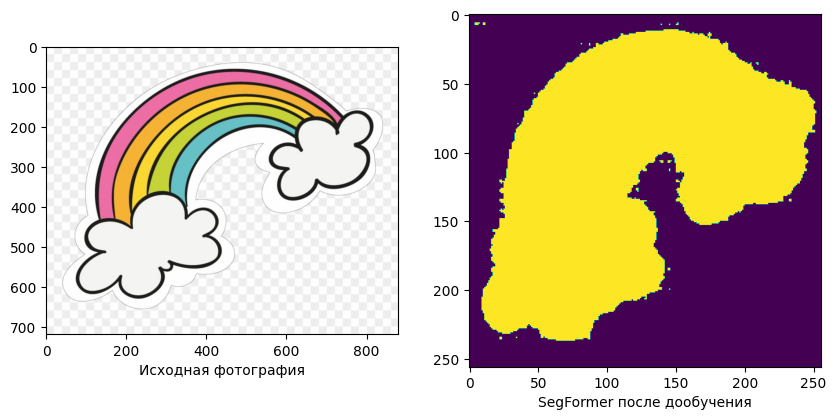

In [14]:
img = Image.open("/kaggle/input/example-image/image.jpg").convert("RGB")
img_tensor = image_processor(img, return_tensors="pt")
img_tensor["pixel_values"] = img_tensor["pixel_values"].to(device)

outputs = model(**img_tensor).logits
outputs = nn.functional.interpolate(outputs, size=(256, 256), mode="bilinear", align_corners=False)
outputs = outputs.argmax(dim=1).permute(1, 2, 0).detach().cpu().numpy()

fig = plt.figure(figsize=(10, 7)) 
fig.add_subplot(1, 2, 1) 
plt.xlabel("Исходная фотография")
plt.imshow(img)

fig.add_subplot(1, 2, 2) 
plt.xlabel("SegFormer после дообучения")
plt.imshow(outputs)

plt.show()